In [1]:
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
raw_df = pd.read_csv('./proj_2_mal_sample/mixed_beg_final.csv')
raw_df.head()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,attack_type
0,8.667644,60.000000,4.550000e-13,10.655350,60.00000,1.360000e-12,15.820060,60.000000,5.370000e-11,171.914833,...,0.000000,0.000000,1.000000,60.000000,0.000000,60.000000,0.000000e+00,0.000000,0.000000,6
1,112.335958,740.833501,4.383973e+05,183.686936,743.00623,4.379898e+05,530.170077,744.404328,4.365826e+05,5160.390170,...,0.000000,0.000000,27388.029910,161.639834,215.630401,161.639834,4.649647e+04,0.000000,0.000000,8
2,46.322431,1394.814020,5.654087e+04,79.823752,1397.34386,5.237410e+04,257.341249,1401.574114,4.567435e+04,1694.191532,...,-44.325301,-0.030503,2527.951527,1401.501744,212.244492,1402.807062,4.504781e+04,-346.854191,-0.174733,5
3,1790.596293,60.000000,3.180000e-12,2695.274398,60.00000,6.820000e-12,6578.443327,60.000000,1.360000e-11,16835.155630,...,0.000000,0.000000,1.000000,60.000000,0.000000,60.000000,0.000000e+00,0.000000,0.000000,3
4,7364.317054,136.000000,4.370000e-11,12263.146570,136.00000,4.730000e-11,36763.799320,136.000000,1.240000e-10,344484.849200,...,0.000000,0.000000,12.635007,136.000000,0.000004,136.000000,1.820000e-11,0.000000,0.000000,4


In [4]:
cleaned_df = raw_df.copy()

In [5]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [6]:
train_labels = np.array(train_df.pop('attack_type'))
val_labels = np.array(val_df.pop('attack_type'))
test_labels = np.array(test_df.pop('attack_type'))

In [7]:
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

In [9]:
METRICS = [
    'accuracy'
]

In [10]:
def make_model(metrics=METRICS):
        
    model = tf.keras.Sequential([
    layers.Dense(115, activation=tf.nn.relu, input_shape=(train_features.shape[-1],)),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(115, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(9, activation=tf.nn.softmax)
    ])

    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=metrics)

    return model

In [11]:
EPOCHS = 200
BATCH_SIZE = 8192

checkpoint_filepath = './checkpoints'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

In [12]:
model = make_model()


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 115)               13340     
                                                                 
 dropout (Dropout)           (None, 115)               0         
                                                                 
 dense_1 (Dense)             (None, 115)               13340     
                                                                 
 dropout_1 (Dropout)         (None, 115)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                7424      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4

In [14]:
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/200
3/3 [==============================] - 2s 154ms/step - loss: 2.2141 - accuracy: 0.1227 - val_loss: 2.0564 - val_accuracy: 0.2322
Epoch 2/200
3/3 [==============================] - 0s 85ms/step - loss: 2.1021 - accuracy: 0.1818 - val_loss: 1.9143 - val_accuracy: 0.3694
Epoch 3/200
3/3 [==============================] - 0s 55ms/step - loss: 1.9991 - accuracy: 0.2282 - val_loss: 1.7769 - val_accuracy: 0.4836
Epoch 4/200
3/3 [==============================] - 0s 54ms/step - loss: 1.8995 - accuracy: 0.2689 - val_loss: 1.6690 - val_accuracy: 0.4900
Epoch 5/200
3/3 [==============================] - 0s 59ms/step - loss: 1.8089 - accuracy: 0.3154 - val_loss: 1.5793 - val_accuracy: 0.5167
Epoch 6/200
3/3 [==============================] - 0s 50ms/step - loss: 1.7362 - accuracy: 0.3453 - val_loss: 1.4999 - val_accuracy: 0.5366
Epoch 7/200
3/3 [==============================] - 0s 54ms/step - loss: 1.6753 - accuracy: 0.3638 - val_loss: 1.4212 - val_accuracy: 0.5442
Epoch 8/200
3/3 [==

3/3 [==============================] - 0s 31ms/step - loss: 0.4996 - accuracy: 0.8345 - val_loss: 0.3739 - val_accuracy: 0.8956
Epoch 60/200
3/3 [==============================] - 0s 53ms/step - loss: 0.4787 - accuracy: 0.8380 - val_loss: 0.3612 - val_accuracy: 0.9042
Epoch 61/200
3/3 [==============================] - 0s 48ms/step - loss: 0.4793 - accuracy: 0.8378 - val_loss: 0.3547 - val_accuracy: 0.9051
Epoch 62/200
3/3 [==============================] - 0s 31ms/step - loss: 0.4619 - accuracy: 0.8447 - val_loss: 0.3531 - val_accuracy: 0.9002
Epoch 63/200
3/3 [==============================] - 0s 59ms/step - loss: 0.4642 - accuracy: 0.8469 - val_loss: 0.3461 - val_accuracy: 0.9058
Epoch 64/200
3/3 [==============================] - 0s 50ms/step - loss: 0.4538 - accuracy: 0.8497 - val_loss: 0.3391 - val_accuracy: 0.9072
Epoch 65/200
3/3 [==============================] - 0s 22ms/step - loss: 0.4416 - accuracy: 0.8563 - val_loss: 0.3319 - val_accuracy: 0.9056
Epoch 66/200
3/3 [========

3/3 [==============================] - 0s 19ms/step - loss: 0.2919 - accuracy: 0.9123 - val_loss: 0.2425 - val_accuracy: 0.9201
Epoch 118/200
3/3 [==============================] - 0s 33ms/step - loss: 0.2846 - accuracy: 0.9138 - val_loss: 0.2397 - val_accuracy: 0.9231
Epoch 119/200
3/3 [==============================] - 0s 63ms/step - loss: 0.2826 - accuracy: 0.9150 - val_loss: 0.2389 - val_accuracy: 0.9269
Epoch 120/200
3/3 [==============================] - 0s 21ms/step - loss: 0.2799 - accuracy: 0.9165 - val_loss: 0.2472 - val_accuracy: 0.9213
Epoch 121/200
3/3 [==============================] - 0s 22ms/step - loss: 0.2805 - accuracy: 0.9152 - val_loss: 0.2423 - val_accuracy: 0.9245
Epoch 122/200
3/3 [==============================] - 0s 22ms/step - loss: 0.2747 - accuracy: 0.9174 - val_loss: 0.2375 - val_accuracy: 0.9250
Epoch 123/200
3/3 [==============================] - 0s 19ms/step - loss: 0.2725 - accuracy: 0.9170 - val_loss: 0.2351 - val_accuracy: 0.9262
Epoch 124/200
3/3 [=

Epoch 175/200
3/3 [==============================] - 0s 20ms/step - loss: 0.2193 - accuracy: 0.9344 - val_loss: 0.1943 - val_accuracy: 0.9403
Epoch 176/200
3/3 [==============================] - 0s 33ms/step - loss: 0.2120 - accuracy: 0.9376 - val_loss: 0.1936 - val_accuracy: 0.9400
Epoch 177/200
3/3 [==============================] - 0s 20ms/step - loss: 0.2118 - accuracy: 0.9379 - val_loss: 0.2059 - val_accuracy: 0.9352
Epoch 178/200
3/3 [==============================] - 0s 23ms/step - loss: 0.2128 - accuracy: 0.9380 - val_loss: 0.1910 - val_accuracy: 0.9435
Epoch 179/200
3/3 [==============================] - 0s 26ms/step - loss: 0.2140 - accuracy: 0.9366 - val_loss: 0.1986 - val_accuracy: 0.9366
Epoch 180/200
3/3 [==============================] - 0s 30ms/step - loss: 0.2149 - accuracy: 0.9365 - val_loss: 0.1954 - val_accuracy: 0.9394
Epoch 181/200
3/3 [==============================] - 0s 28ms/step - loss: 0.2154 - accuracy: 0.9381 - val_loss: 0.1945 - val_accuracy: 0.9373
Epoch 

In [15]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

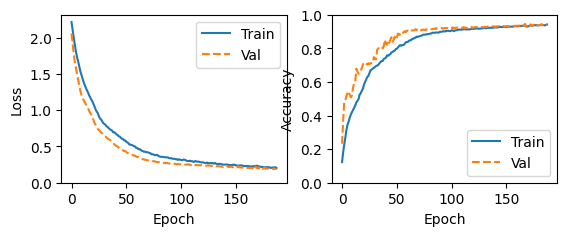

In [16]:
plot_metrics(baseline_history)

In [17]:
model.load_weights(checkpoint_filepath)

In [18]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

1/1 [==============================] - 0s 30ms/step


In [19]:
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions, normalize = 'true')
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt=".2f")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


In [20]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, 
                                  verbose=0)

In [21]:
test_predictions_max = np.argmax(test_predictions_baseline, axis=1)

In [22]:
print(classification_report(test_labels, test_predictions_max))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       620
           1       0.86      1.00      0.92       576
           2       0.96      1.00      0.98       613
           3       1.00      1.00      1.00       624
           4       1.00      1.00      1.00       570
           5       0.99      0.99      0.99       593
           6       0.96      1.00      0.98       588
           7       0.96      0.99      0.98       594
           8       0.99      0.62      0.76       622

    accuracy                           0.95      5400
   macro avg       0.96      0.95      0.95      5400
weighted avg       0.96      0.95      0.95      5400



In [23]:
confusion_matrix(test_labels, test_predictions_max, normalize = 'pred')

array([[0.88905109, 0.01639344, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.00145985, 0.85692996, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.96377953, 0.        , 0.        ,
        0.00167224, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.9984    , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.0015748 , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.00145985, 0.        , 0.0015748 , 0.        , 0.        ,
        0.98662207, 0.00163934, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.96393443, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.95786062, 0.00769231],


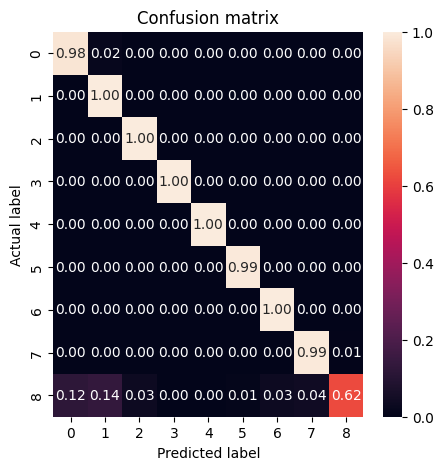

In [24]:
plot_cm(test_labels, test_predictions_max)